# 1.Exploratory Data Analysis (EDA)

This notebook performs exploratory analysis ONLY on Phase 1 data.

Rationale:
- Phase 1 is the only dataset allowed for full statistical analysis.
- Phase 2 and Test datasets contain forecast windows and must not be used
  for learning patterns to avoid data leakage.

Scope:
- Distribution analysis
- Seasonality inspection
- Missing value checks
- Series-level behavior

Excluded:
- Phase 2 and Test deep EDA

## 1.1 Import Libraries

In [47]:
# =========================
# Import Libraries
# =========================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 50)
plt.style.use("seaborn-v0_8")

## 1.2 Load Dataset

In [48]:
# -------------------------
# Load data
# -------------------------
phase1 = pd.read_csv("../data/processed/phase1.csv", parse_dates=["timestamp"])
phase2 = pd.read_csv("../data/processed/phase2.csv", parse_dates=["timestamp"])
test   = pd.read_csv("../data/processed/test.csv",   parse_dates=["timestamp"])

phase1.head()

,series_id,timestamp,value
0,Building3,2016-03-02 02:01:00,1321.0
1,Building3,2016-03-02 02:16:00,1321.0
2,Building3,2016-03-02 02:31:00,1321.0
3,Building3,2016-03-02 02:46:00,1293.0
4,Building3,2016-03-02 03:01:00,1293.0


## 1.3 Dataset Overview

In [49]:
# -------------------------
# Basic overview
# -------------------------

print("\nSeries count (Phase 1):")
print(phase1.groupby("series_id").size().sort_values(ascending=False))

phase1.info()
phase1.describe()


Series count (Phase 1):
series_id
Building3    160221
Solar1        61387
Solar5        59947
Solar2        46407
Solar3        46407
Solar4        46407
Building4     26095
Solar0        15207
Building5     11579
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473657 entries, 0 to 473656
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   series_id  473657 non-null  object        
 1   timestamp  473657 non-null  datetime64[ns]
 2   value      473657 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 10.8+ MB


,timestamp,value
count,473657,473657.000000
mean,2019-07-02 12:34:12.913520640,177.184217
min,2016-03-02 02:01:00,0.000000
25%,2019-03-14 19:15:00,0.000000
50%,2019-10-27 19:16:00,2.390000
75%,2020-04-24 17:00:00,311.000000
max,2020-10-01 21:16:00,8556.000000
std,NaN,291.103612


## 1.4 Data Preparation

In [50]:
# -------------------------
# Missing values check
# -------------------------
print("\nMissing values:")
print(phase1.isna().sum())


Missing values:
series_id    0
timestamp    0
value        0
dtype: int64


In [51]:
# -------------------------
# Frequency check
# -------------------------
sample_series = "Building3"
sample = phase1[phase1.series_id == sample_series].copy()
sample = sample.sort_values("timestamp")

delta = sample.timestamp.diff().value_counts().head()
print("\nTime delta check:")
print(delta)


Time delta check:
timestamp
0 days 00:15:00    160198
0 days 00:30:00        15
0 days 01:15:00         2
4 days 16:15:00         1
0 days 05:00:00         1
Name: count, dtype: int64


## 1.5 Data Visualization

#### 1.5.1 Distribution & outliers
Histogram/KDE dan boxplot per `series_id` untuk melihat sebaran nilai dan perbandingan Building vs Solar.

/tmp/ipykernel_34055/2696095538.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=phase1, x="series_id", y="value", order=order, ax=axes[1], palette="viridis")


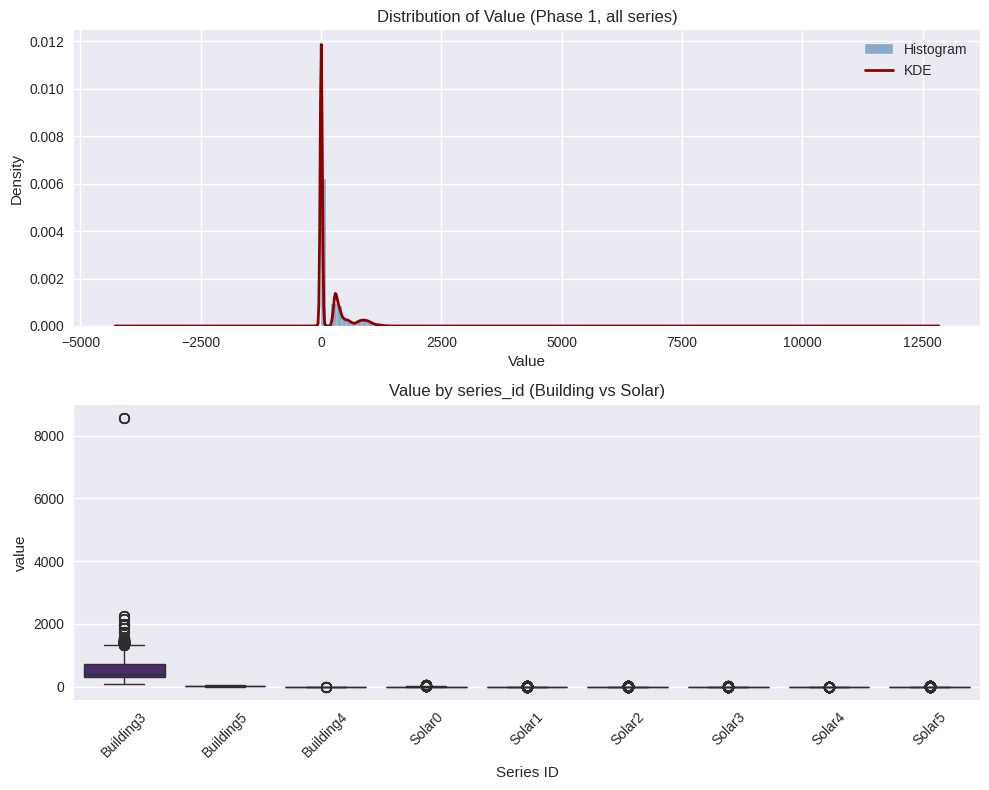

In [52]:
# Distribution of value (overall and per series)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Overall histogram + KDE
phase1["value"].hist(bins=80, ax=axes[0], density=True, alpha=0.6, label="Histogram", color="steelblue", edgecolor="white")
phase1["value"].plot.kde(ax=axes[0], color="darkred", linewidth=2, label="KDE")
axes[0].set_title("Distribution of Value (Phase 1, all series)")
axes[0].set_xlabel("Value")
axes[0].legend()

# Boxplot per series_id
order = phase1.groupby("series_id")["value"].median().sort_values(ascending=False).index
sns.boxplot(data=phase1, x="series_id", y="value", order=order, ax=axes[1], palette="viridis")
axes[1].set_title("Value by series_id (Building vs Solar)")
axes[1].set_xlabel("Series ID")
axes[1].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.savefig("../results/figures/eda/distribution_value.png", dpi=150, bbox_inches="tight")
plt.show()

#### 1.5.2 Per-series comparison (Building vs Solar)
Daily mean untuk beberapa series agar pola Building dan Solar bisa dibandingkan.

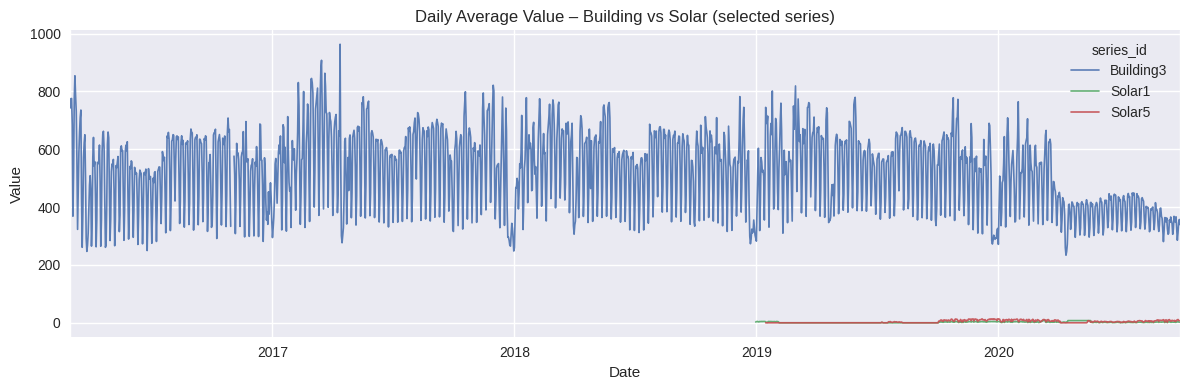

In [53]:
# Compare a few series: 1 Building + 2 Solar
compare_ids = ["Building3", "Solar1", "Solar5"]
compare = phase1[phase1["series_id"].isin(compare_ids)].copy()
daily_multi = compare.set_index("timestamp").groupby("series_id")["value"].resample("D").mean().unstack(0)

fig, ax = plt.subplots(figsize=(12, 4))
daily_multi.plot(ax=ax, linewidth=1.2, alpha=0.9)
ax.set_title("Daily Average Value – Building vs Solar (selected series)")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend(title="series_id")
plt.tight_layout()
plt.savefig("../results/figures/eda/daily_average_value.png", dpi=150, bbox_inches="tight")
plt.show()

#### 1.5.3 Hour × Day of week heatmap
Pola musiman sekaligus: nilai rata-rata per jam dan hari dalam seminggu.

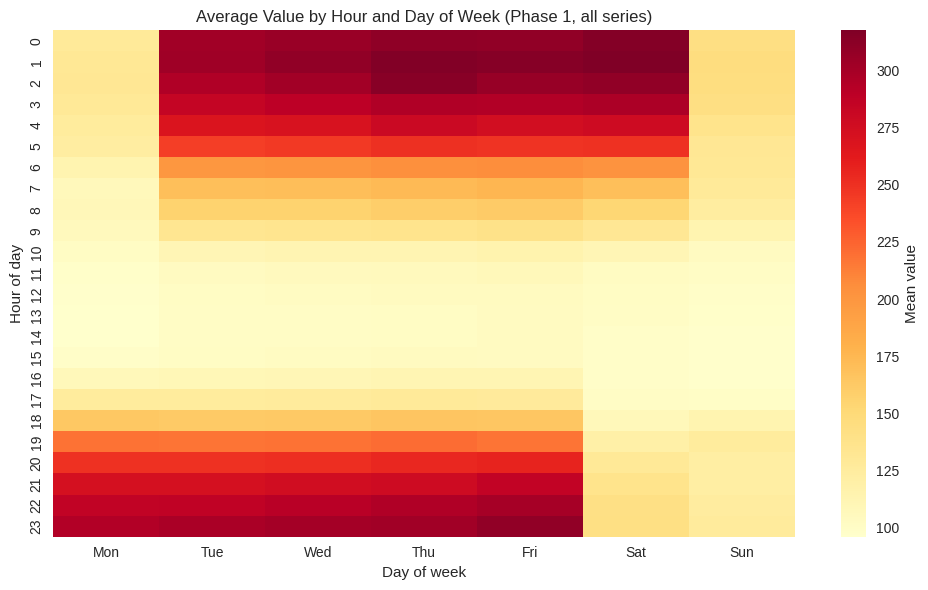

In [54]:
# Heatmap: mean value by hour (rows) x day_of_week (columns)
# Ensure hour/dayofweek exist (they are created in the "Average by hour/dayofweek" cell)
if "hour" not in phase1.columns:
    phase1["hour"] = phase1["timestamp"].dt.hour
if "dayofweek" not in phase1.columns:
    phase1["dayofweek"] = phase1["timestamp"].dt.dayofweek
pivot = phase1.pivot_table(values="value", index="hour", columns="dayofweek", aggfunc="mean")
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
pivot.columns = day_names

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, cmap="YlOrRd", ax=ax, cbar_kws={"label": "Mean value"})
ax.set_title("Average Value by Hour and Day of Week (Phase 1, all series)")
ax.set_xlabel("Day of week")
ax.set_ylabel("Hour of day")
plt.tight_layout()
plt.savefig("../results/figures/eda/daily_average_value_by_hour_and_day_of_week.png", dpi=150, bbox_inches="tight")
plt.show()

#### 1.5.4 Autocorrelation (ACF)
ACF untuk melihat ketergantungan temporal dan memilih lag/window yang masuk akal untuk model.

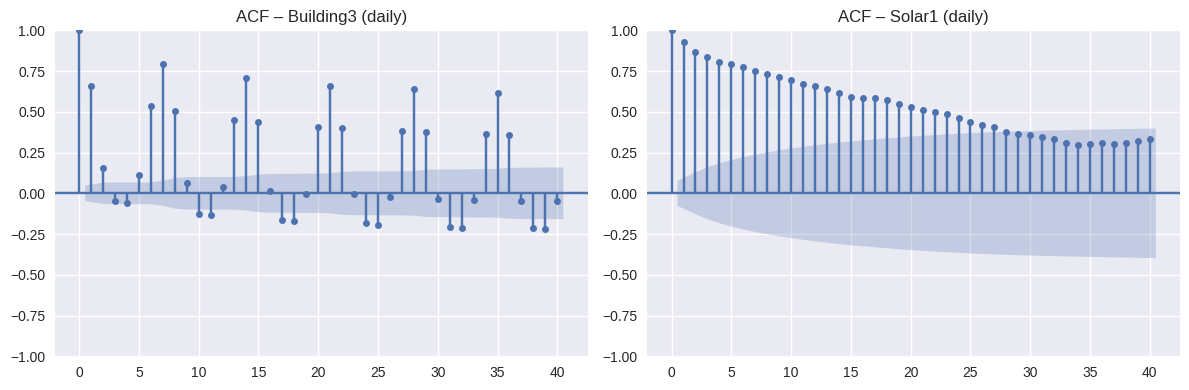

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Use daily series to keep ACF interpretable (e.g. lag in days)
acf_series = ["Building3", "Solar1"]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, sid in zip(axes, acf_series):
    ts = phase1.loc[phase1["series_id"] == sid].set_index("timestamp")["value"].sort_index().resample("D").mean()
    nlag = max(1, min(40, len(ts) // 2 - 1))
    plot_acf(ts.dropna(), lags=nlag, ax=ax, title=f"ACF – {sid} (daily)")
plt.tight_layout()
plt.savefig("../results/figures/eda/acf.png", dpi=150, bbox_inches="tight")
plt.show()

#### 1.5.5 Data coverage and gaps
Jumlah observasi per hari per series untuk mendeteksi periode kosong atau tidak lengkap.

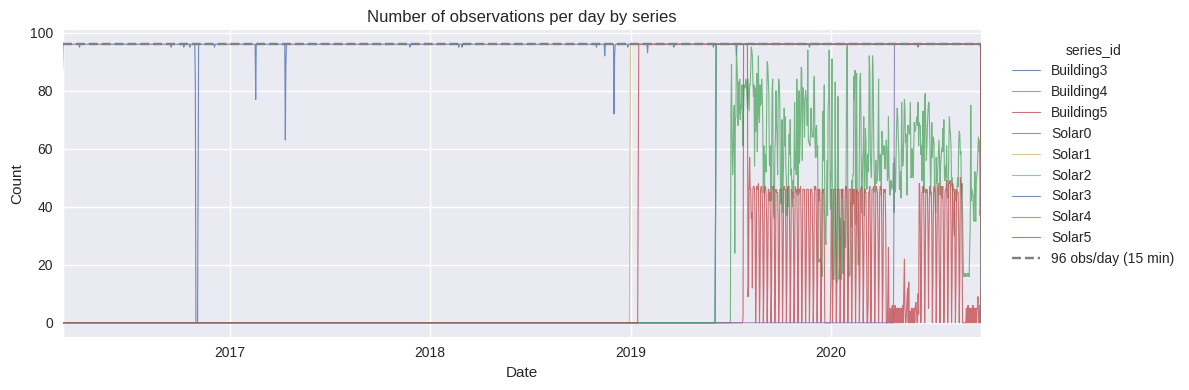

In [ ]:
# Observations per day per series (expected ≈ 96 for 15-min data)
obs_per_day = (
    phase1.set_index("timestamp")
    .groupby("series_id")
    .resample("D")["value"]
    .count()
    .unstack(0, fill_value=0)
)
fig, ax = plt.subplots(figsize=(12, 4))
obs_per_day.plot(ax=ax, linewidth=0.8, alpha=0.8)
ax.axhline(96, color="gray", linestyle="--", label="96 obs/day (15 min)")
ax.set_title("Number of observations per day by series")
ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.legend(title="series_id", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../results/figures/eda/obs_per_day.png", dpi=150, bbox_inches="tight")
plt.show()

## 1.6 Sanity Chechk on Phase 2 and Test

In [ ]:
print("Phase 2 value range:", phase2["value"].min(), phase2["value"].max())
print("Test value range:", test["value"].min(), test["value"].max())

Phase 2 value range: 0.0 8556.0
Test value range: 0.0 8556.0
